In [415]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.nn.functional import relu, softmax


import seaborn as sns
sns.set(rc={'figure.figsize': (16, 9.)})

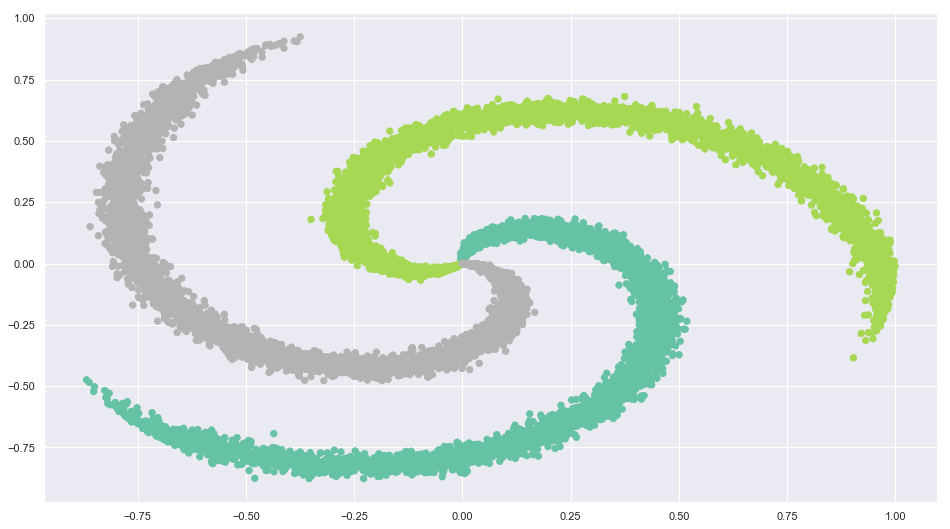

In [416]:
N = 5000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

radius = 1.
angle = 4
vol = 0.1


X = np.zeros((N * K, D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, radius, N) # radius
    t = np.linspace(j*angle, (j+1) * angle, N) + np.random.randn(N) * vol # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Set2)
plt.show()

X_input, y_input = X, y

In [417]:
X, X_test, y, y_test = train_test_split(X_input , y_input, test_size=0.05)

In [418]:
# numpy to tensor
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

X_test = torch.FloatTensor(X_test)

In [419]:
plot_step = 0.2
otsput = 0.2

x_min, x_max = X[:, 0].min() - otsput, X[:, 0].max() + otsput
y_min, y_max = X[:, 1].min() - otsput, X[:, 1].max() + otsput
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))


## Decision trees

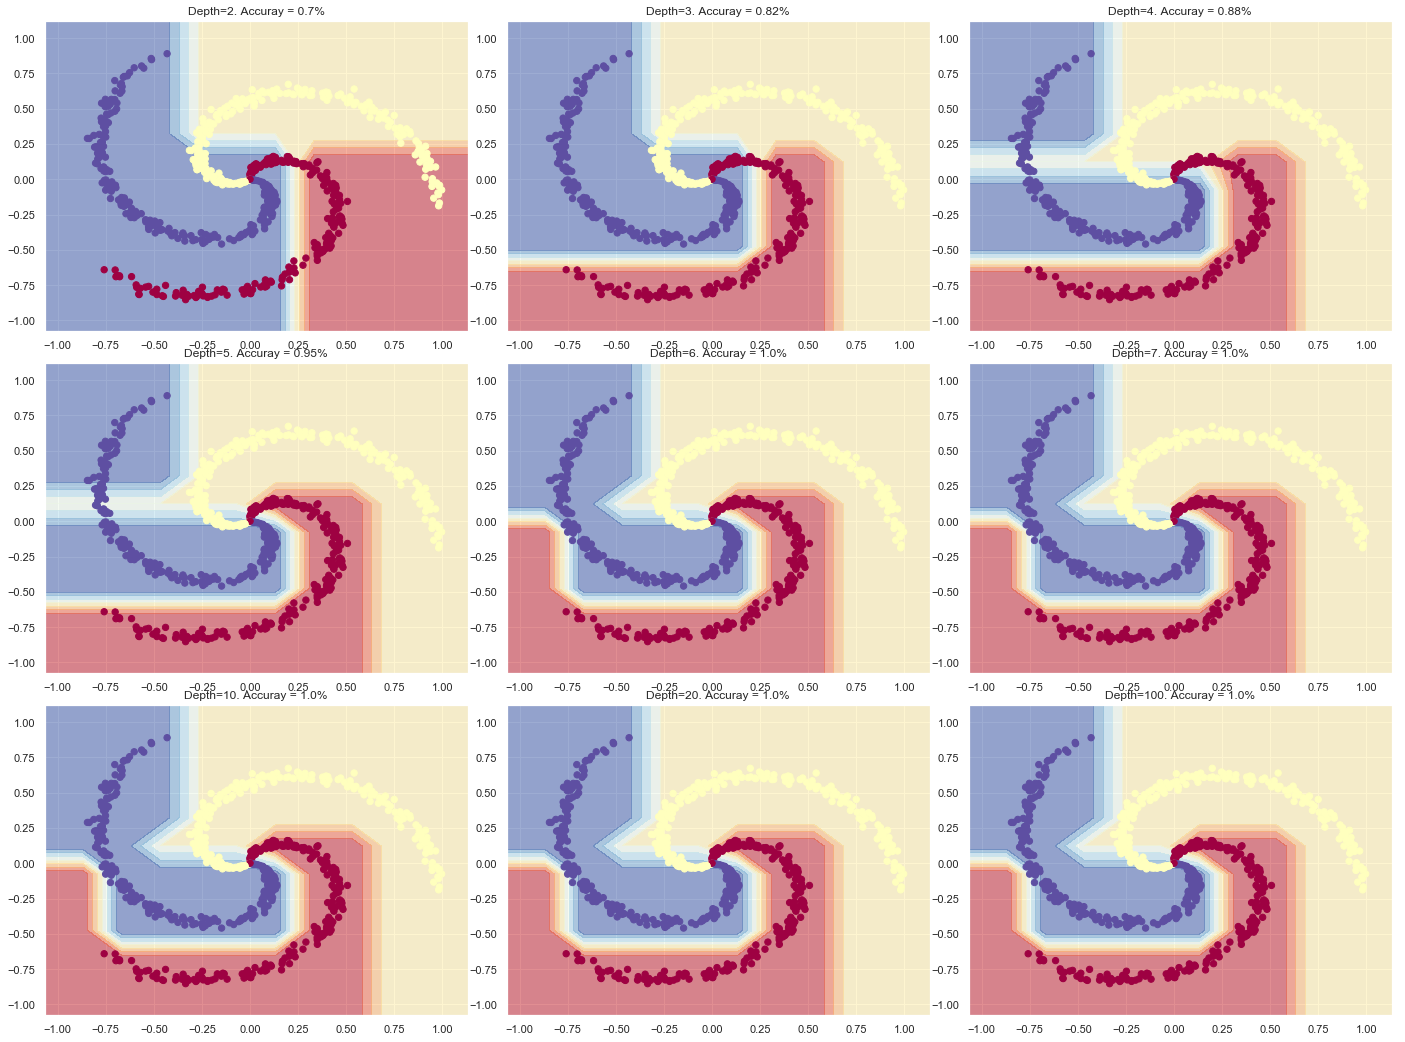

In [420]:
fig, axes = plt.subplots(figsize=(20.0, 15.0), nrows=3, ncols=3)
axes = axes.reshape(-1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5) 

trees = {}

for idx, depth in enumerate([2,3,4,5,6,7, 10,20, 100]):
    clf = tree.DecisionTreeClassifier(max_depth=depth).fit(X,y)
    Z_ = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z_.reshape(xx.shape)
    
    trees[depth] = clf
    
    accur = accuracy_score(clf.predict(X_test), y_test)
    
    axes[idx][0].set_title(f'Depth={depth}. Accuray = {round(accur,2)}%')
    axes[idx][0].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.5)
    axes[idx][0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)

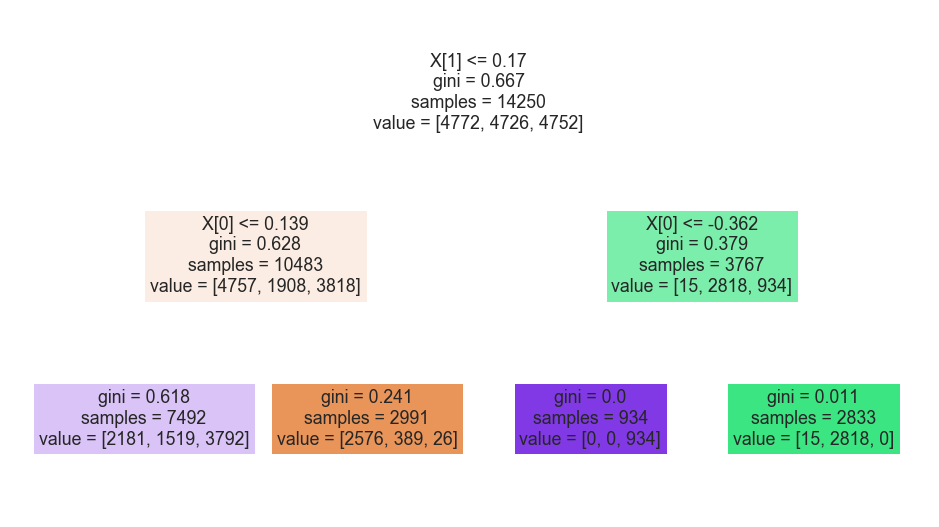

In [421]:
tree.plot_tree(trees[2], filled=True);

## PyTorch MyClass

In [426]:
dimIn = D
dimOut = K

class VertuhaNet(nn.Module):
    
    def __init__(self, layerSize, nbLayer=1):
        super().__init__()
        
        hiddenDims = [layerSize for _ in range(1, nbLayer+1)]
        self.dimensions = [D, *hiddenDims, K]
        self.layers = nn.ModuleList([nn.Linear(d1, d2) for d1, d2 in zip(self.dimensions[0:-1], self.dimensions[1:])])

        
        
    def forward(self, X):
        a = X
        for layer in self.layers[:-1]:
            a = relu(layer(a))
        return softmax(self.layers[-1](a), -1)
    
    def fit(self, X, y):
        lossF = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(self.parameters(), 1e-2)

        for _ in range(100):
            # forward
            y_pred = model(X) # __call__ == forward

            #loss
            loss = lossF(y_pred, y)
            losses.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()
            
    def predict(self, X):
        predictions = self.forward(X)
        res = []
        for pred in predictions:
            res.append(int(torch.argmax(pred)))
            
        return np.array(res)
        
    

In [427]:
model = VertuhaNet(layerSize=30)

In [428]:
model.layers

ModuleList(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Linear(in_features=30, out_features=3, bias=True)
)

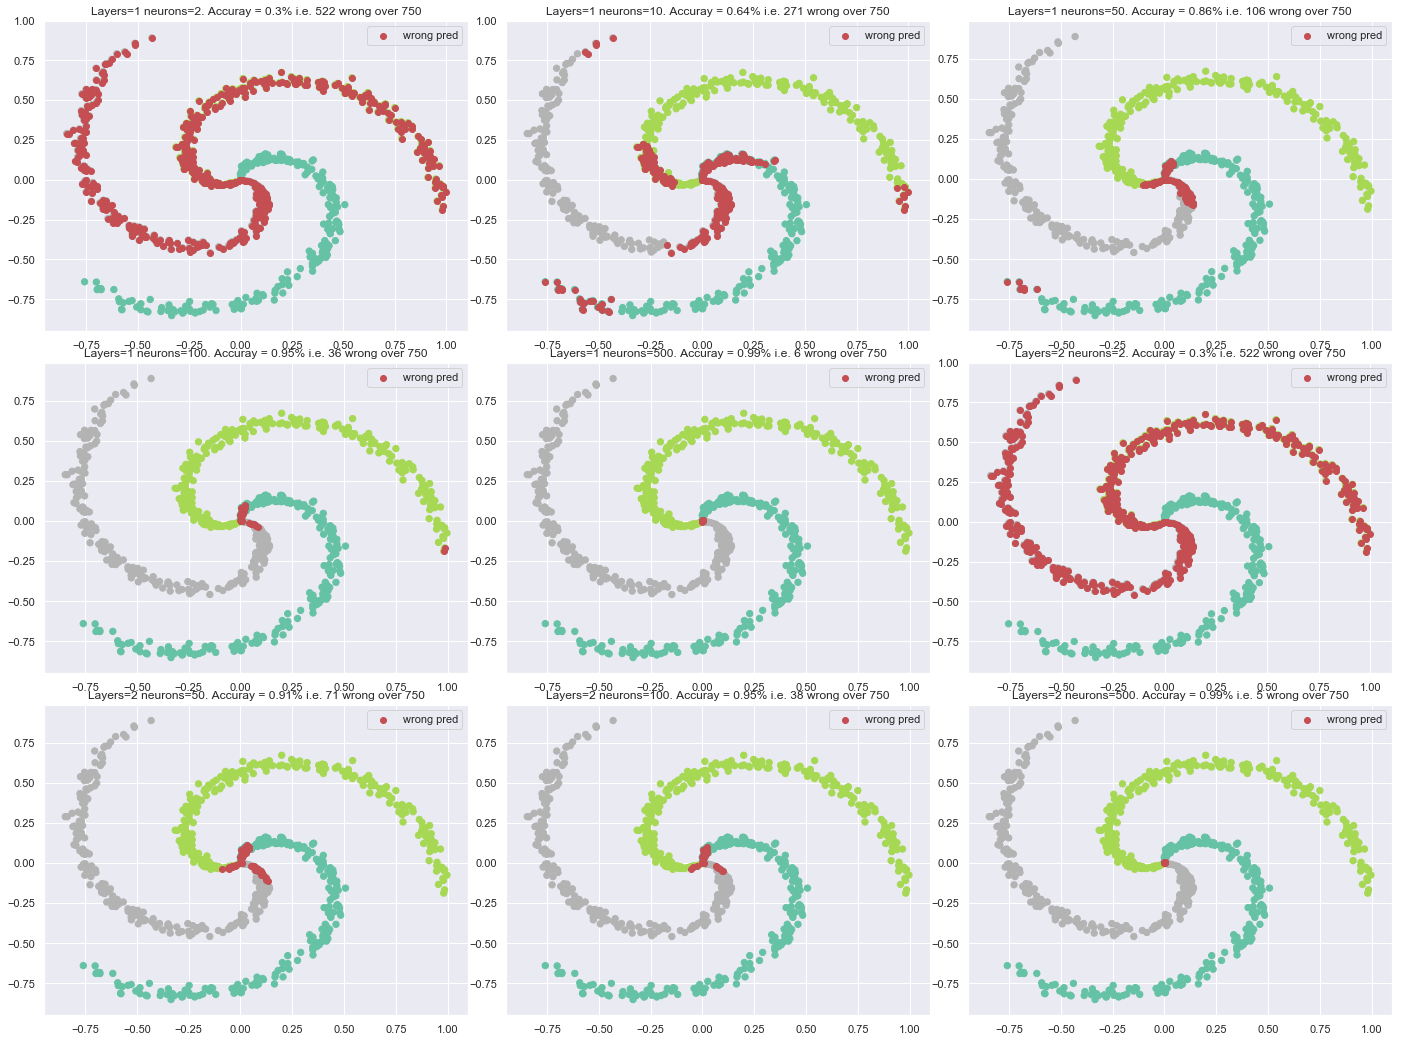

In [429]:
fig, axes = plt.subplots(figsize=(20.0, 15.0), nrows=3, ncols=3)
axes = axes.reshape(-1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5) 

nns = {}
for idx, (layerSize, nbL) in enumerate([(2,1),(10,1),(50,1), (100,1),(500,1),(2,2), (50,2), (100,2), (500,2)]):
    

    model = VertuhaNet(layerSize=layerSize)
    model.fit(X, y)
    y_pred = model.predict(X_test)
    
    nns[hiddenL] = model
    
    accur = accuracy_score(model.predict(X_test), y_test)
    
    axes[idx][0].set_title(f'Layers={nbL} neurons={layerSize}. Accuray = {round(accur,2)}% i.e. {sum(y_test != y_pred)} wrong over {len(y_test)}')
    axes[idx][0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Set2)
    X_test_plot = X_test[y_test != y_pred]
    axes[idx][0].scatter(X_test_plot[:, 0], X_test_plot[:, 1], marker='o', color='r', zorder=10, label='wrong pred')
    axes[idx][0].legend()